# Comparación red neuronal regresión

## Importar librerías

In [28]:
import os
from sklearn.datasets import fetch_california_housing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from sklearn.datasets import load_breast_cancer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import keras_tuner as kt
import numpy as np
import tensorflow as tf
import random as random
import pandas as pd

In [29]:
# Comprobar GPU y configurar memoria
print(tf.__version__)

gpus = tf.config.list_physical_devices("GPU")
print("GPUs:", gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU habilitada")
    except RuntimeError as e:
        print("Error al configurar GPU:", e)
else:
    print("No se detectaron GPUs")

2.16.1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU habilitada


## Importar datos

In [30]:
california_housing = fetch_california_housing(as_frame=True)

df = california_housing.frame

## Análisis explotario de datos

In [31]:
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [32]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


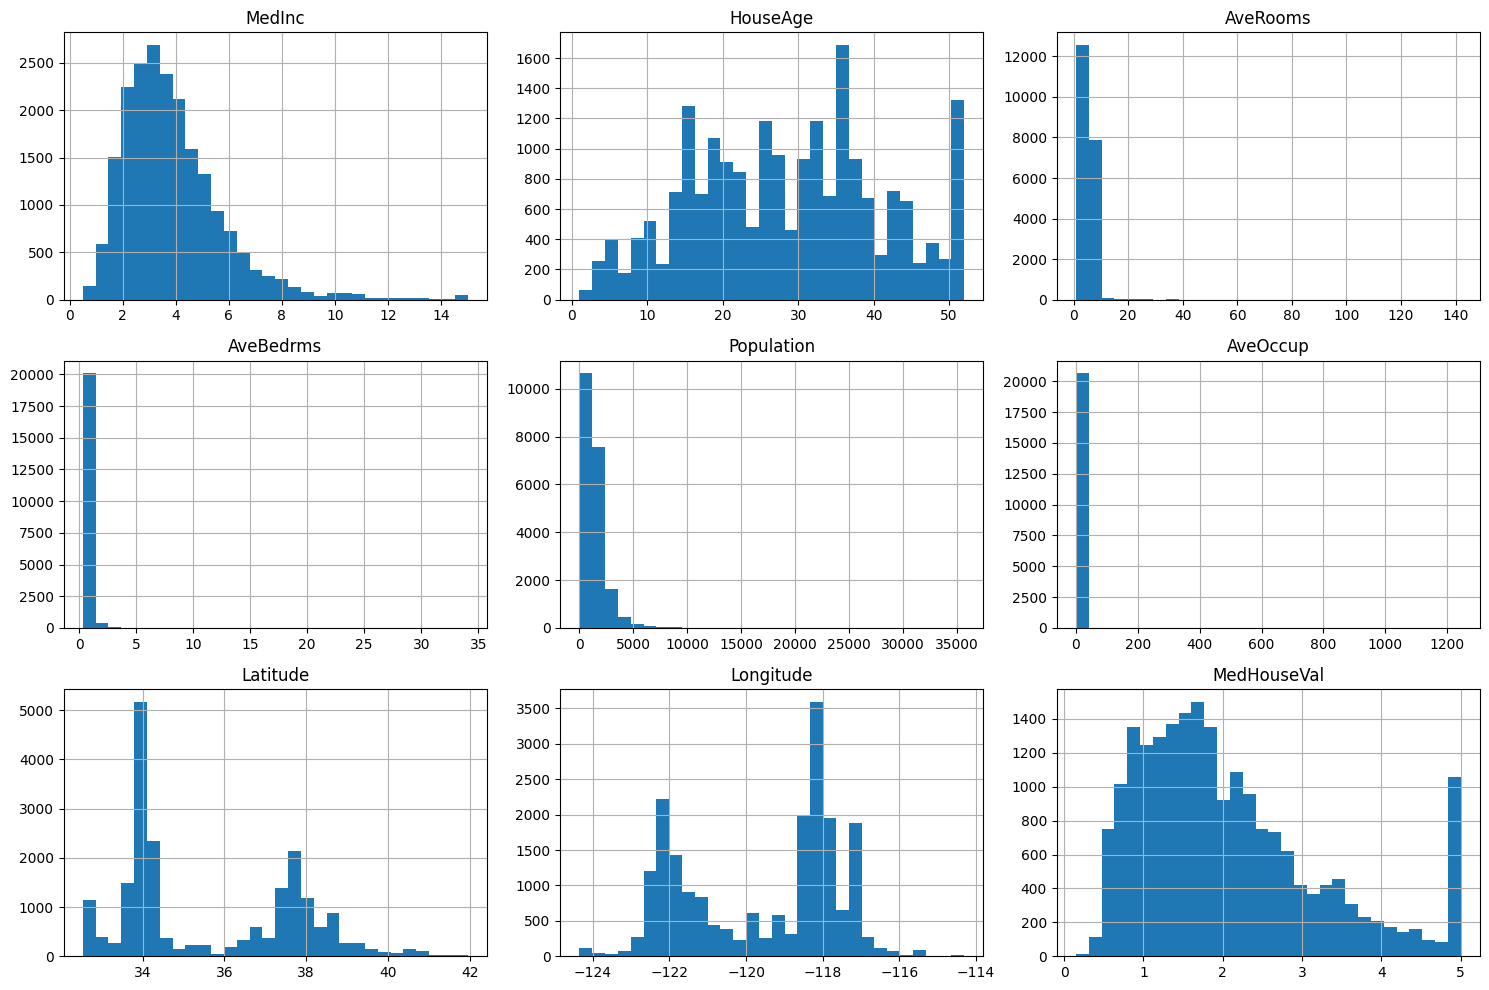

In [33]:
# Ver distribución de las variables
import matplotlib.pyplot as plt

df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [34]:
# Definir semilla para reproducibilidad
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
set_seed(42)

In [35]:
# Configurar ruta de salida de modelos en el directorio de trabajo 
output_dir = os.path.join(os.getcwd(), 'models/')

In [36]:
# Escalar los datos (features y variable objetivo)
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(df.drop(columns=['MedHouseVal']))
y = df['MedHouseVal'].values.reshape(-1, 1)
y_scaled = scaler_y.fit_transform(y).ravel()

In [37]:
# Dividir los datos en conjunto de entrenamiento y prueba (usando los datos escalados)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2)

## Optimizador Bayesiano

In [38]:
# Función para crear el modelo
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1],)))
    
    num_layers = hp.Int('num_layers', min_value=1, max_value=5, step=1)
    l2_factor = hp.Choice('l2_factor', values=[0.0, 1e-5, 1e-4, 1e-3])
    dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.1, 0.2, 0.3])
    
    for i in range(num_layers):
        units = hp.Int(f'units_{i}', min_value=16, max_value=256, step=16)
        activation = hp.Choice(f'activation_{i}', values=['relu', 'tanh', 'sigmoid'])
        model.add(
            Dense(
                units=units,
                activation=activation,
                kernel_regularizer=regularizers.l2(l2_factor)
            )
        )
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))
            
    model.add(Dense(1, activation='sigmoid'))  # Capa de salida para regresión
        
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

In [39]:
# Configurar primer optimizador de hiperparámetros

turner = kt.BayesianOptimization(
    build_model,
    objective='val_mae',
    max_trials=20,
    num_initial_points=10,
    executions_per_trial=1,
    directory=output_dir,
    project_name='california_housing_regression',
)

es_tuner = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

turner.search(
    X_train,
    y_train_scaled,
    epochs=50,
    validation_data=(X_test, y_test_scaled),
    callbacks=[es_tuner],
)

best_hps = turner.get_best_hyperparameters(num_trials=1)[0]
print(f"Mejores hiperparámetros: {best_hps.values}")

Reloading Tuner from /home/jovyan/work/models/california_housing_regression/tuner0.json
Mejores hiperparámetros: {'num_layers': 3, 'units_0': 112, 'activation_0': 'tanh', 'units_1': 80, 'activation_1': 'sigmoid', 'units_2': 64, 'activation_2': 'relu', 'units_3': 16, 'activation_3': 'sigmoid', 'units_4': 80, 'activation_4': 'sigmoid', 'l2_factor': 0.0, 'dropout_rate': 0.0, 'learning_rate': 0.01, 'optimizer': 'rmsprop'}


In [40]:
# Modelo final con los mejores hiperparámetros
model = turner.hypermodel.build(best_hps)

cp = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_mae', mode='min')
es = EarlyStopping(monitor='val_mae', patience=15, restore_best_weights=True)

model.fit(
    X_train,
    y_train_scaled,
    epochs=200,
    validation_data=(X_test, y_test_scaled),
    callbacks=[cp, es],
    verbose=0
)

test_metrics = model.evaluate(X_test, y_test_scaled, verbose=0)
print(f"MAE en el conjunto de prueba (escalado): {test_metrics[1]}")

y_pred_scaled = model.predict(X_test, verbose=0).ravel()

MAE en el conjunto de prueba (escalado): 0.6303091049194336


In [41]:
# Desescalar predicciones y valores reales para calcular el MAE en la escala original
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_test_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()

mae = mean_absolute_error(y_test_real, y_pred)
print(f"MAE en validación: {mae}")

MAE en validación: 0.7273314849847047


In [42]:
# Comparar valores originales vs predichos (desescalados)

# Desescalar ambos arrays
y_test_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# Crear un DataFrame para comparar
comparacion = pd.DataFrame({
    'Valor real': y_test_real,
    'Predicción': y_pred
})

comparacion.head(10)

,Valor real,Predicción
0,0.47700,2.068558
1,0.45800,2.068563
2,5.00001,3.222486
3,2.18600,2.765354
4,2.78000,2.328892
5,1.58700,2.068559
6,1.98200,2.288093
7,1.57500,2.068558
8,3.40000,2.369635
9,4.46600,3.222486


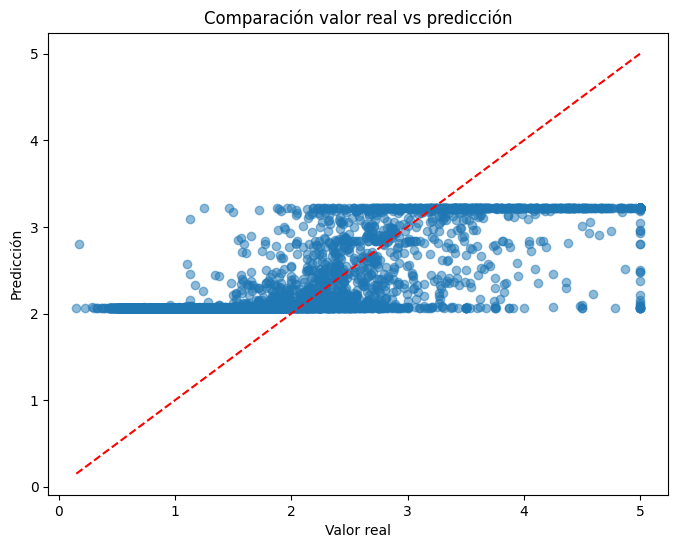

In [43]:
# Visualizar errores de predicción (valor real vs predicho)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, y_pred, alpha=0.5)
plt.plot([y_test_real.min(), y_test_real.max()], [y_test_real.min(), y_test_real.max()], 'r--')
plt.xlabel('Valor real')
plt.ylabel('Predicción')
plt.title('Comparación valor real vs predicción')
plt.show()

## Random Search

In [44]:
def build_model(hp):
    model = Sequential()

    # Definir número de capas
    for i in range(hp.Int('num_layers', 2, 5)):  # Probar entre 2 y 5 capas
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=64, step=16),
                        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))

    model.add(Dense(1, activation='sigmoid'))  # Capa de salida

    # Definir el optimizador con el learning rate como hiperparámetro
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mse',
                  metrics=['mae'])
    return model

In [45]:
# Crear el tuner
tuner = kt.RandomSearch(
    build_model,  # La función que construye el modelo
    objective='val_mae',  # Objetivo a optimizar
    max_trials=5,  # Número máximo de pruebas
    executions_per_trial=1,  # Número de ejecuciones por prueba
    directory=output_dir,  # Directorio donde guardar los resultados
    project_name='california_housing_random_search',  # Nombre del proyecto
)

# Ejecutar la búsqueda
tuner.search(X_train, y_train_scaled, epochs=30, validation_data=(X_test, y_test_scaled))

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Mejores hiperparámetros: {best_hps.values}")

Reloading Tuner from /home/jovyan/work/models/california_housing_random_search/tuner0.json
Mejores hiperparámetros: {'num_layers': 4, 'units_0': 64, 'activation': 'relu', 'units_1': 16, 'learning_rate': 0.0008433633337952192, 'units_2': 16, 'units_3': 16}


In [46]:
# Crear el modelo final con los mejores hiperparámetros
model = tuner.hypermodel.build(best_hps)

cp = ModelCheckpoint(filepath="best_ckpt.r.weights.h5", monitor='val_mae', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

model.fit(X_train, y_train_scaled,
          epochs=30,
          validation_data=(X_test, y_test_scaled),
          callbacks=[cp, es],
          verbose=0)



# Evaluar el modelo en el conjunto de prueba
test_accuracy = model.evaluate(X_test, y_test_scaled)
print(f"Precisión en el conjunto de prueba: {test_accuracy[1]}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step - loss: 0.5954 - mae: 0.6351
Precisión en el conjunto de prueba: 0.6369399428367615


In [47]:
# Comparar valores originales vs predichos (desescalados)

# Desescalar ambos arrays
y_test_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()
y_pred_scaled = model.predict(X_test, verbose=0).ravel()
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

comparacion = pd.DataFrame({
    'Valor real': y_test_real,
    'Predicción': y_pred
})

comparacion.head(10)

,Valor real,Predicción
0,0.47700,2.068559
1,0.45800,2.071204
2,5.00001,3.222067
3,2.18600,2.687373
4,2.78000,3.049753
5,1.58700,2.069359
6,1.98200,2.159169
7,1.57500,2.068692
8,3.40000,2.570017
9,4.46600,3.222183


## Grid Search

In [48]:
def build_model(hp):
    model = Sequential()

    # Definir número de capas
    for i in range(hp.Int('num_layers', 2, 5)):  # Probar entre 2 y 5 capas
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=64, step=16),
                        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))

    model.add(Dense(1, activation='sigmoid'))  # Capa de salida

    # Definir el optimizador con el learning rate como hiperparámetro
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mse',
                  metrics=['mae'])
    return model

In [49]:
tuner = kt.GridSearch(
    build_model,
    objective='val_mae',
    max_trials=5,
    executions_per_trial=1,
    directory=output_dir,
    project_name='california_housing_gridsearch',
)

tuner.search(X_train, y_train_scaled, epochs=30, validation_data=(X_test, y_test_scaled))

best_hps = tuner.get_best_hyperparameters()[0]
print(f"Mejores hiperparámetros: {best_hps.values}")

Reloading Tuner from /home/jovyan/work/models/california_housing_gridsearch/tuner0.json
Mejores hiperparámetros: {'num_layers': 2, 'units_0': 16, 'activation': 'relu', 'units_1': 16, 'learning_rate': 0.007943282347242817}


In [ ]:
model = tuner.hypermodel.build(best_hps)

cp = ModelCheckpoint(filepath="best_ckpt.g.weights.h5", monitor='val_mae', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

model.fit(X_train, y_train_scaled,
          epochs=30,
          validation_data=(X_test, y_test_scaled),
          callbacks=[cp, es],
          verbose=0)

test_accuracy = model.evaluate(X_test, y_test_scaled)
print(f"Precisión en el conjunto de prueba: {test_accuracy[1]}")

/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with vale_mae available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 0.5970 - mae: 0.6351
Precisión en el conjunto de prueba: 0.6362709999084473


In [51]:
# Comparar valores originales vs predichos (desescalados)

# Desescalar ambos arrays
y_test_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel()
y_pred_scaled = model.predict(X_test, verbose=0).ravel() 
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel() 
comparacion = pd.DataFrame({ 'Valor real': y_test_real, 'Predicción': y_pred }) 

comparacion.head(10)

,Valor real,Predicción
0,0.47700,2.068558
1,0.45800,2.068812
2,5.00001,3.222470
3,2.18600,2.805953
4,2.78000,3.053751
5,1.58700,2.074745
6,1.98200,2.184748
7,1.57500,2.068676
8,3.40000,2.587258
9,4.46600,3.222485


## Hyperband

In [52]:
def build_model(hp):
    model = Sequential()

    # Definir el número de capas (Hyperparameter for num_layers)
    num_layers = hp.Int('num_layers', min_value=2, max_value=5)  # Número de capas entre 2 y 5

    # Añadir capas dinámicamente en función del número de capas seleccionado
    for i in range(num_layers):
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=16, max_value=64, step=16),
                        activation=hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])))

    model.add(Dense(1, activation='sigmoid'))  # Capa de salida

    # Definir el optimizador con el learning rate como hiperparámetro
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mse',
                  metrics=['mae'])
    return model

In [53]:
tuner = kt.Hyperband(
    build_model,
    objective='val_mae',
    max_epochs=30,
    hyperband_iterations=2,
    directory=output_dir,
    project_name='california_housing_hyperband',
)

# Ejecutar la búsqueda
tuner.search(X_train, y_train_scaled, epochs=30, validation_data=(X_test, y_test_scaled))

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Mejores hiperparámetros: {best_hps.values}")


Trial 180 Complete [00h 00m 18s]
val_mae: 0.6374931335449219

Best val_mae So Far: 0.6277740597724915
Total elapsed time: 00h 15m 29s
Mejores hiperparámetros: {'num_layers': 3, 'units_0': 48, 'activation': 'relu', 'units_1': 48, 'learning_rate': 0.006439485147843038, 'units_2': 32, 'units_3': 64, 'units_4': 16, 'tuner/epochs': 30, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


In [55]:
model = tuner.hypermodel.build(best_hps)

cp = ModelCheckpoint(filepath="best_ckpt.hb.weights.h5", monitor='val_mae', save_best_only=True, save_weights_only=True)
es = EarlyStopping(monitor='val_mae', patience=5, restore_best_weights=True)

model.fit(X_train, y_train_scaled,
          epochs=30,
          validation_data=(X_test, y_test_scaled),
          callbacks=[cp, es],
          verbose=0)



# Evaluar el modelo en el conjunto de prueba
test_accuracy = model.evaluate(X_test, y_test_scaled)
print(f"Precisión en el conjunto de prueba: {test_accuracy[1]}")

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 0.5896 - mae: 0.6312
Precisión en el conjunto de prueba: 0.6291781067848206


In [57]:
# Comparar valores originales vs predichos (desescalados)

# Desescalar ambos arrays
y_test_real = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).ravel() 
y_pred_scaled = model.predict(X_test, verbose=0).ravel() 
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel() 
comparacion = pd.DataFrame({ 'Valor real': y_test_real, 'Predicción': y_pred }) 
comparacion.head(10)

,Valor real,Predicción
0,0.47700,2.068558
1,0.45800,2.068558
2,5.00001,3.222486
3,2.18600,2.827569
4,2.78000,2.118797
5,1.58700,2.068590
6,1.98200,2.250633
7,1.57500,2.068558
8,3.40000,2.797354
9,4.46600,3.222486
